# Quickstart: Collisional Ionization Equilibrium

Example of using `jaco` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from jaco.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network['e-']}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*C_2*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*C_2*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
RHS of e- number density equation: Eq(Derivative(n_e-(t), t), -1.41621465870114e-10*C_2*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252))


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

system.subprocesses

[Collisional Ionization of H,
 Collisional Ionization of He,
 Collisional Ionization of He+,
 Gas-phase recombination of H+,
 Gas-phase recombination of He+,
 Gas-phase recombination of He++]

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [4]:
system.heat

-1.55e-26*C_2*n_He+*n_e-/T**0.3647 - 1.46719838641439e-26*C_2*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 5.86879354565754e-26*C_2*sqrt(T)*n_He++*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252) - 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

## Solving ionization equilibrium

We would like to solve for ionization equilibrium given a temperature $T$, overall H number density $n_{\rm H,tot}$.  We define a dictionary of those input quantities and also one for the initial guesses of the number densities of the species in the reduced network.

In [5]:
Tgrid = np.logspace(3,6,10**6)
ngrid = np.ones_like(Tgrid) * 100

knowns = {"T": Tgrid, "n_Htot": ngrid}

guesses = {
    "H+": 0.9*np.ones_like(Tgrid),
    "He+": 1e-2*np.ones_like(Tgrid),
    "He++": 1e-2*np.ones_like(Tgrid)
}

Note that by default, the solver only directly solves for $n_{\rm H+}$, $n_{\rm He+}$ and $n_{\rm He++}$ because and $n_{\rm e-}$ and all atomic species are eliminated by conservation equations. So we only need initial guesses for those 3 quantities. By default the solver takes abundances $x_i = n_i / n_{\rm H,tot}$ as inputs and outputs.

The `solve` method calls the JAX solver and computes the solution:

In [6]:
sol = system.solve(knowns, guesses,tol=1e-3, verbose=True,careful_steps=30)
print(sol)

Undetermined symbols: {x_He+, y, n_Htot, x_H+, T, C_2, x_He++}
y not specified; assuming y=0.09254634923706946.
C_2 not specified; assuming C_2=1.0.
Free symbols: {x_He+, y, n_Htot, x_H+, T, C_2, x_He++}
Known values: ['T', 'n_Htot']
Assumed values: ['y', 'C_2']
Equations solved: ['He++', 'H+', 'He+']
It's solvin time. Solving for {'He++', 'He+', 'H+'} based on input {'T', 'n_Htot'} and assumptions about {'y', 'C_2'}
num_iter average=35.86250305175781 min=18 max=68
{'He+': Array([8.259601e-17, 8.259580e-17, 8.259559e-17, ..., 7.692539e-06,
       7.692447e-06, 7.692356e-06], dtype=float32), 'H+': Array([4.1381906e-16, 4.1381869e-16, 4.1381975e-16, ..., 9.9999940e-01,
       9.9999940e-01, 9.9999940e-01], dtype=float32), 'He++': Array([1.4600168e-18, 1.4600135e-18, 1.4600135e-18, ..., 9.2538655e-02,
       9.2538655e-02, 9.2538655e-02], dtype=float32), 'He': Array([9.254635e-02, 9.254635e-02, 9.254635e-02, ..., 7.450581e-09,
       7.450581e-09, 7.450581e-09], dtype=float32), 'H': Array

(0.0001, 3)

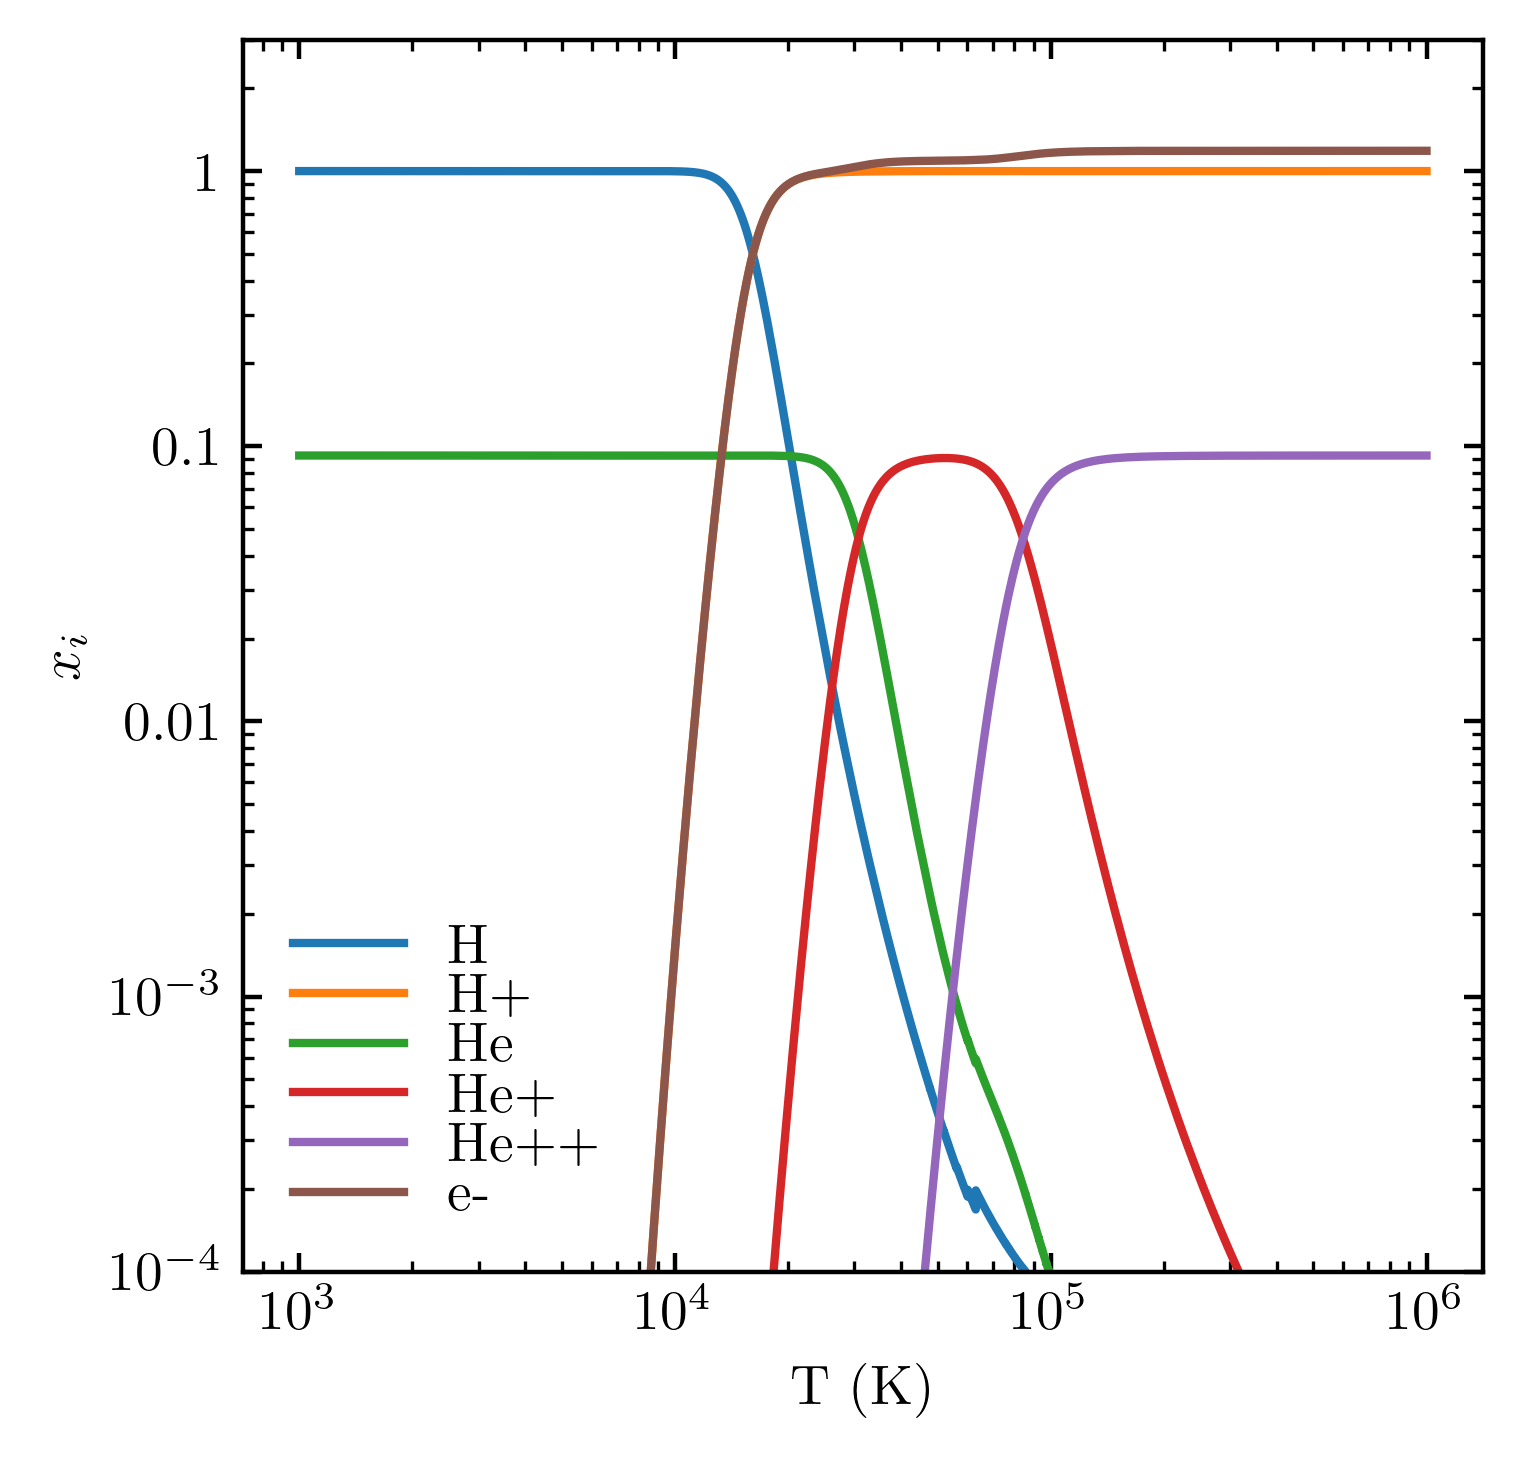

In [7]:
for i, xi in sorted(sol.items()):
    plt.loglog(Tgrid, xi, label=i)
plt.legend(labelspacing=0)
plt.ylabel("$x_i$")
plt.xlabel("T (K)")
plt.ylim(1e-4,3)

## Generating code

Suppose you just want the RHS of the system you're solving, or its Jacobian, because you have a better solver and/or want to embed these equations in some old C or Fortran code without any dependencies. You can do that too with `generate_code`.

In [8]:
print(system.generate_code(('H+','He+','He++'),language='c'))

/* Computes the RHS function and Jacobian to solve for [x_He+, x_H+, x_He++]

This code was auto-generated by jaco v0.1.1 and is not intended to be modified or maintained by human beings.

INDEX CONVENTION: (0: x_He+) (1: x_H+) (2: x_He++)
*/

x0 = sqrt(T); 
x1 = pow(0.2818075618324889*x0 + 1.0, -0.252); 
x2 = pow(0.00059608348423850961*x0 + 1.0, -1.748); 
x3 = 5.664858634804579e-10*x1*x2; 
x4 = pow(n_Htot, 2); 
x5 = x_Heplus + 2*x_Heplusplus + x_Hplus; 
x6 = x4*x5; 
x7 = 1.0/x0; 
x8 = C_2*x7; 
x9 = x6*x8; 
x10 = x3*x9; 
x11 = x10*x_Heplusplus; 
x12 = x4*x_Heplus; 
x13 = 1.0/T; 
x14 = exp(-631515*x13); 
x15 = 1.0/((1.0/1000.0)*sqrt(10)*x0 + 1); 
x16 = x0*x15; 
x17 = 5.68e-12*x14*x16; 
x18 = x12*x17; 
x19 = x18*x5; 
x20 = exp(-285335.40000000002*x13); 
x21 = -x_Heplus - x_Heplusplus + y; 
x22 = C_2*(0.0019*pow(T, -1.5)*(1 + 0.29999999999999999*exp(-94000.0*x13))*exp(-470000.0*x13) + 1.9324160622805846e-10*x7*pow(0.00016493478118851054*x0 + 1.0, -1.7891999999999999)*pow(4.841607448117723

Let's break down what happened there. First, jaco is generating the symbolic functions needed to solve the system, as it needs to do before it solves the system with its own solver:

In [9]:
func, jac, _ = system.network.solver_functions(('H','He','He+'),return_jac=True)

Here `func` represents the set of functions $f_i$ such that $f_i = 0$ solves the system. `jac` encodes the Jacbian of f $J_{ij} = \frac{\partial f_i}{\partial x_j}$ of derivatives with respect to the solved variables. Note that the two have many common expressions - before being implemented, one should employ common expression elimination to simplify the code and evaluate the functions more efficiently:

In [10]:
cse, (cse_func, cse_jac) = sp.cse((sp.Matrix(func),sp.Matrix(jac)))

cse

[(x0, sqrt(T)),
 (x1, 1/x0),
 (x2, n_Htot**2),
 (x3, x_H+ + x_He+ + 2*x_He++),
 (x4, (0.00059608348423851*x0 + 1.0)**(-1.748)),
 (x5, (0.281807561832489*x0 + 1.0)**(-0.252)),
 (x6, x2*x_He+),
 (x7, 1/T),
 (x8, 1/(sqrt(10)*x0/1000 + 1)),
 (x9, x0*x8),
 (x10, 5.68e-12*x9*exp(-631515*x7)),
 (x11, x10*x6),
 (x12, exp(-285335.4*x7)),
 (x13, -x_He+ - x_He++ + y),
 (x14,
  C_2*(0.0019*(1 + 0.3*exp(-94000.0*x7))*exp(-470000.0*x7)/T**1.5 + 1.93241606228058e-10*x1/((0.000164934781188511*x0 + 1.0)**1.7892*(4.84160744811772*x0 + 1.0)**0.2108))),
 (x15, x14*x6),
 (x16, x2*x3)]

In [11]:
cse_func

Matrix([[5.66485863480458e-10*C_2*x1*x2*x3*x4*x5*x_He++ + 2.38e-11*x0*x12*x13*x2*x3*x8 - x11*x3 - x15*x3]])

In [12]:
cse_jac

Matrix([[5.66485863480458e-10*C_2*x1*x2*x4*x5*x_He++ + 2.38e-11*x0*x12*x13*x2*x8 - x10*x16 - x11 - 2.38e-11*x12*x16*x9 - x14*x16 - x15]])

One can then take these expressions and convert them to the syntax of the code you wish to embed them in: 

In [13]:
from sympy.codegen.ast import Assignment
for expr in cse:
    print(sp.ccode(Assignment(*expr),standard='c99'))

rhs_result = sp.MatrixSymbol('rhs_result', len(func), 1)
jac_result = sp.MatrixSymbol('jac_result', len(func),len(func))
print()
print(sp.ccode(Assignment(rhs_result, cse_func),standard='c99'))
print()
print(sp.ccode(Assignment(jac_result, cse_jac),standard='c99'))

x0 = sqrt(T);
x1 = 1.0/x0;
x2 = pow(n_Htot, 2);
x3 = x_H+ + x_He+ + 2*x_He++;
x4 = pow(0.00059608348423850961*x0 + 1.0, -1.748);
x5 = pow(0.2818075618324889*x0 + 1.0, -0.252);
x6 = x2*x_He+;
x7 = 1.0/T;
x8 = 1.0/((1.0/1000.0)*sqrt(10)*x0 + 1);
x9 = x0*x8;
x10 = 5.68e-12*x9*exp(-631515*x7);
x11 = x10*x6;
x12 = exp(-285335.40000000002*x7);
x13 = -x_He+ - x_He++ + y;
x14 = C_2*(0.0019*pow(T, -1.5)*(1 + 0.29999999999999999*exp(-94000.0*x7))*exp(-470000.0*x7) + 1.9324160622805846e-10*x1*pow(0.00016493478118851054*x0 + 1.0, -1.7891999999999999)*pow(4.8416074481177231*x0 + 1.0, -0.21079999999999999));
x15 = x14*x6;
x16 = x2*x3;

rhs_result[0] = 5.664858634804579e-10*C_2*x1*x2*x3*x4*x5*x_He++ + 2.3800000000000001e-11*x0*x12*x13*x2*x3*x8 - x11*x3 - x15*x3;

jac_result[0] = 5.664858634804579e-10*C_2*x1*x2*x4*x5*x_He++ + 2.3800000000000001e-11*x0*x12*x13*x2*x8 - x10*x16 - x11 - 2.3800000000000001e-11*x12*x16*x9 - x14*x16 - x15;
